Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - conversion_efficiency_output_loss: 0.0062 - conversion_efficiency_output_mae: 0.0372 - drop_off_output_accuracy: 0.9545 - drop_off_output_loss: 0.1187 - loss: 0.1249 - val_conversion_efficiency_output_loss: 2.8736e-04 - val_conversion_efficiency_output_mae: 0.0127 - val_drop_off_output_accuracy: 0.9923 - val_drop_off_output_loss: 0.0193 - val_loss: 0.0196
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - conversion_efficiency_output_loss: 3.1935e-04 - conversion_efficiency_output_mae: 0.0132 - drop_off_output_accuracy: 0.9921 - drop_off_output_loss: 0.0194 - loss: 0.0198 - val_conversion_efficiency_output_loss: 1.1513e-04 - val_conversion_efficiency_output_mae: 0.0083 - val_drop_off_output_accuracy: 0.9969 - val_drop_off_output_loss: 0.0090 - val_loss: 0.0092
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - conversion_efficiency_output_loss: 2.1240e-04 - conversion_efficiency_output_mae: 0.0102 - drop_off_output_accur

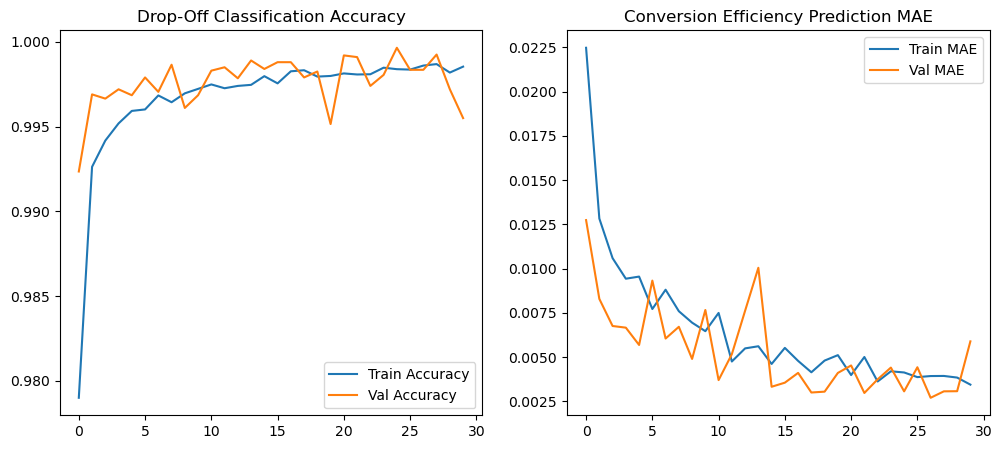

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step
Predictions saved to predicted_click_behavior.csv


In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load dataset
file_path = r"C:\Users\samhe\OneDrive\Documents\AI Project 3 - Customer Behavior\click_behavior_analysis_with_drop_off.csv"
df = pd.read_csv(file_path)

# Define feature columns
features = [
    "clicks", "impressions", "ad_ctr", "ad_cpc", "ad_spend", 
    "click_to_purchase_ratio", "conversion_rate"
]

# Target variables
X = df[features]
y_classification = df["drop_off"].astype(np.float32)  # Ensure correct data type
y_regression = df["conversion_rate"].astype(np.float32)

# Split into training and testing sets
X_train, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split(
    X, y_classification, y_regression, test_size=0.2, random_state=42
)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compute class weights for classification
total_samples = len(y_train_class)
num_class_0 = np.sum(y_train_class == 0)
num_class_1 = np.sum(y_train_class == 1)
class_weight_0 = total_samples / (2 * num_class_0)
class_weight_1 = total_samples / (2 * num_class_1)

# Define weighted binary cross-entropy loss with correct casting
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.where(y_true == 0, tf.cast(class_weight_0, tf.float32), tf.cast(class_weight_1, tf.float32))
    return tf.reduce_mean(weights * tf.keras.losses.binary_crossentropy(y_true, y_pred))

# Build the Multi-Task Learning (MTL) model
input_shape = X_train_scaled.shape[1]
inputs = keras.Input(shape=(input_shape,))

# Shared hidden layers
x = layers.Dense(128, activation="relu")(inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)

# Separate classification branch
classification_branch = layers.Dense(16, activation="relu")(x)
classification_output = layers.Dense(1, activation="sigmoid", name="drop_off_output")(classification_branch)

# Separate regression branch
regression_branch = layers.Dense(16, activation="relu")(x)
regression_output = layers.Dense(1, activation="linear", name="conversion_efficiency_output")(regression_branch)

# Define the model
model = keras.Model(inputs=inputs, outputs=[classification_output, regression_output])

# Compile the model
model.compile(
    optimizer="adam",
    loss={
        "drop_off_output": weighted_binary_crossentropy,  # Classification with custom weighting
        "conversion_efficiency_output": "mse",  # Regression
    },
    metrics={
        "drop_off_output": ["accuracy"],
        "conversion_efficiency_output": ["mae"],
    }
)

# Train the model with early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(
    X_train_scaled, 
    {"drop_off_output": y_train_class, "conversion_efficiency_output": y_train_reg},
    validation_data=(X_test_scaled, {"drop_off_output": y_test_class, "conversion_efficiency_output": y_test_reg}),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Save the model
model.save("click_behavior_mtl_model.h5")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["drop_off_output_accuracy"], label="Train Accuracy")
plt.plot(history.history["val_drop_off_output_accuracy"], label="Val Accuracy")
plt.title("Drop-Off Classification Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["conversion_efficiency_output_mae"], label="Train MAE")
plt.plot(history.history["val_conversion_efficiency_output_mae"], label="Val MAE")
plt.title("Conversion Efficiency Prediction MAE")
plt.legend()
plt.show()

# Generate predictions
predictions = model.predict(X_test_scaled)

df_predictions = pd.DataFrame({
    "Actual_Drop_Off": y_test_class,
    "Predicted_Drop_Off": (predictions[0] > 0.5).astype(int).flatten(),
    "Actual_Conversion_Efficiency": y_test_reg,
    "Predicted_Conversion_Efficiency": predictions[1].flatten()
})

# Save predictions to CSV
df_predictions.to_csv("predicted_click_behavior.csv", index=False)
print("Predictions saved to predicted_click_behavior.csv")
